# 0.0 Imports

## 0.1 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection

## 0.2 Helper Functions



In [3]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Data Loading



In [3]:
df0 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')
# source https://www.kaggle.com/vik2012kvs/high-value-customers-identification
# other https://github.com/provezano/UK-High-Value-Customers-Identification/tree/main/data

## 0.4 Columns Description



### Attribute Description
- InvoiceNo Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode Product (item) code
- Description Product (item) name
- Quantity The quantities of each product (item) per transaction
- InvoiceDate The day when each transaction was generated
- UnitPrice Unit price (Product price per unit)
- CustomerID Customer number (Unique ID assigned to each customer)
- Country Country name (The name of the country where each customer resides)

## 0.5 Solution Method

### IOT Input Output Visualizing

The aim is to build a data solution similar to this [draft](https://docs.google.com/spreadsheets/d/1zmBQAxvlx-nWgziQZmoL7lx-F1maMAMp5qlVD2c6AyA/edit?usp=sharing)

Situation: The organization will roll out a fidelity program (Insiders Program) to these customers. Customers should be segmented in a way that it is possible to find the most valuable customers. 

Inputs:
- Data from customer transactions (11-2016 ~ 12-2017)

Outputs:
 - Which customers are eligible to participate in the Insiders program?
 - How many customers will be part of the group?
 - What are the main characteristics of these customers?
 - What percentage of revenue contribution comes from Insiders?
 - What is the revenue expectation of this group for the coming months?
 - What are the conditions for a person to be eligible for Insiders?
 - What are the conditions for a person to be removed from Insiders?
 - Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
 - What actions can the marketing team take to increase revenue?

### Tasks:
- Which customers are eligible to participate in the Insiders program?
    - High Value
    - High Average Transaction Value
    - High Frequency (customer is frequently buying)
    - Low Recency (customer has bough recently)
    - High LTV
    - High Basket Size

- How many customers will be part of the group?
- What are the main characteristics of these customers?
- What percentage of revenue contribution comes from Insiders?
- What is the revenue expectation of this group for the coming months?
- What are the conditions for a person to be eligible for Insiders?
- What are the conditions for a person to be removed from Insiders?
- Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
- What actions can the marketing team take to increase revenue?

### Business Understanding and Metrics
- RFM Recency Frequency Monetary Analysis
    - Formula: ((Total distinct customers at end of period) - (Total new distinct customers acquired during period)) / (Total distinct customers at start of period)
- Average Customer Spend = Customers Annual Average Spend Per Purchase * Annual Purchase Frequency
- Average Transaction Value = Annual Revenue/ Invoces Raised


# 1.0 Data Description


In [32]:
df1 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')

## 1.1 Rename Columns

In [33]:
cols_old = df1.columns.tolist()

cols_new = [inflection.underscore(col) for col in cols_old]
cols_new

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_id',
 'country',
 'unnamed: 8']

In [34]:
df1.rename(columns = dict(zip(cols_old, cols_new)), inplace = True )

## 1.2 Data Dimensions

In [35]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 9


## 1.3 Data Types

In [19]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
unnamed: 8      float64
dtype: object

## 1.4 NA Check

In [36]:
df1.isna().sum()/df1.shape[0]*100

invoice_no        0.000000
stock_code        0.000000
description       0.268311
quantity          0.000000
invoice_date      0.000000
unit_price        0.000000
customer_id      24.926694
country           0.000000
unnamed: 8      100.000000
dtype: float64

In [37]:
df1.drop(columns=['unnamed: 8'], inplace = True)
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.5 NA Fillout

In [39]:
df1.dropna( subset = 'customer_id', how = 'any', axis = 0, inplace = True)

In [40]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Changing Data Types


In [42]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [51]:
df1.nunique()

invoice_no      22190
stock_code       3684
description      3896
quantity          436
invoice_date      305
unit_price        620
customer_id      4372
country            37
dtype: int64

In [55]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y' )

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [56]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [57]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
quantity,"-80,995.00","80,995.00","161,990.00",12.06,5.00,248.69,0.18,"94,317.56"
unit_price,0.00,"38,970.00","38,970.00",3.46,1.95,69.32,452.22,"246,924.54"
customer_id,"12,346.00","18,287.00","5,941.00","15,287.69","15,152.00","1,713.60",0.03,-1.18


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

## 2.1 Response Variable Mind Map

## 2.2 Hypothesis List

## 2.3 Selected Hypothesis:

**H1:** 

**H2:** 

**H3:** 

**H4:** 

**H5:** 

**H6:** 

**H7:** 

**H8:** 

**H9:** 

**H10:** 

**H11:** 

## 2.4 Feature Engineering

In [297]:
df2 = df1.copy()

In [337]:
# Recency
# days since last purchase (considering first day as day after last invoice)
df_recency = df2[['customer_id', 'invoice_date']].copy()
df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')
df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df2['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace = True)

# Frequency
# nº of transactions a customer did
df_ref= df2[['invoice_no', 'customer_id']].groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_transactions'} ) #'invoice_date',  #['num_of_purchases']

# difference between firts and last transaction
# if nº purchases made = 1: date range =  today - first purchase date
# else last purchase - first purchase
func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days
df_date_range = df2[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})
df_ref = df_ref.merge(df_date_range, on = 'customer_id', how = 'left')
df_ref['frequency'] = df_ref['num_transactions']/df_ref['date_range']

# Monetary
# revenue
df_revenue = df2[['unit_price','quantity','customer_id']].copy()
df_revenue['customer_spend'] = df2['unit_price']*df2['quantity']

# sum and mean of revenue
df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').agg( ['sum', 'mean'] )#.to_flat_index() #.reset_index(level=['customer_id', 'customer_spend'])

df_revenue = pd.DataFrame( df_revenue.to_records() )
cols = {"('customer_spend', 'sum')" : "sum_spend",
       "('customer_spend', 'mean')" : "mean_spend"}
df_revenue.rename(columns = cols, inplace = True ) 


In [336]:
# # Testing transformations
# df_recency = df2[['customer_id', 'invoice_date']].copy()
# df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')
# df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df2['invoice_date']).dt.days
# df_recency.drop(columns=['invoice_date'], inplace = True)
# df_recency[df_recency['customer_id'] == 12347]

# nº of transactions a customer did
# df_ref= df2[['invoice_no', 'customer_id']].groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_transactions'} ) #'invoice_date',  #['num_of_purchases']
# # difference between firts and last transaction
# # if nº purchases made = 1: date range =  today - first purchase date
# # else last purchase - first purchase
# func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days
# df_date_range = df2[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})
# df_ref = df_ref.merge(df_date_range, on = 'customer_id', how = 'left')
# df_ref['frequency'] = df_ref['num_transactions']/df_ref['date_range']
# df_ref.head()

# df_revenue = df2[['unit_price','quantity','customer_id']].copy()
# df_revenue['customer_spend'] = df2['unit_price']*df2['quantity']

# # # sum and mean of revenue

# df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').agg( ['sum', 'mean'] )#.to_flat_index() #.reset_index(level=['customer_id', 'customer_spend'])

# df_revenue = pd.DataFrame( df_revenue.to_records() )
# cols = {"('customer_spend', 'sum')" : "sum_spend",
#        "('customer_spend', 'mean')" : "mean_spend"}
# df_revenue.rename(columns = cols, inplace = True ) 

# df_revenue[df_revenue.customer_id == 17850]
# df_revenue.head()

In [340]:
# Saving dataframe with all transformations
df_processed = df2[['customer_id', 'country']].drop_duplicates('customer_id')
df_processed = df_processed.merge( df_recency, how = 'left',  on = 'customer_id' )
df_processed = df_processed.merge( df_ref,     how = 'left',  on = 'customer_id')
df_processed = df_processed.merge( df_revenue, how = 'left',  on = 'customer_id')
df_processed.head()


,customer_id,country,recency,num_transactions,date_range,frequency,sum_spend,mean_spend
0,17850,United Kingdom,303,312,71,4.394366,5288.63,16.950737
1,13047,United Kingdom,32,196,342,0.573099,3079.10,15.709694
2,12583,France,3,251,371,0.676550,7187.34,28.634821
3,13748,United Kingdom,96,28,278,0.100719,948.25,33.866071
4,15100,United Kingdom,331,6,43,0.139535,635.10,105.850000


In [341]:
df_processed.to_csv('../data/interim/df2_interim.csv', index = False)

# 3.0 Variable Selection

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

### 4.1.2 Numerical Variables

### 4.1.3 Categorical Variables

## 4.2 Bivariate Analysis

### **H1.**

### **H2.**


### **H3.**

### **H4.**

### **H5.**

### **H6.**

### **H7.**

### **H8.**

### **H9.**

### **H10.**

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

# 5.0 Data Preparation

## 5.1 Numerical Variables Preparation

In [11]:
df3 = pd.read_csv('../data/interim/df2_interim.csv')

### 5.1.1 Rescaling

In [14]:
# df3.hist();
num_att = df3.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
customer_id,"12,346.00","18,287.00","5,941.00","15,299.68","15,300.50","1,722.39",0.00,-1.20
recency,1.00,374.00,373.00,92.58,51.00,100.77,1.25,0.43
num_transactions,1.00,"7,983.00","7,982.00",93.05,42.00,232.47,18.15,486.23
date_range,1.00,374.00,373.00,183.38,188.00,118.73,0.03,-1.36
frequency,0.00,162.00,162.00,1.08,0.36,4.73,20.11,522.41
sum_spend,"-4,287.63","279,489.02","283,776.65","1,898.46",648.08,"8,219.35",21.71,607.15
mean_spend,"-4,287.63","3,861.00","8,148.63",28.84,16.92,127.32,2.44,602.36


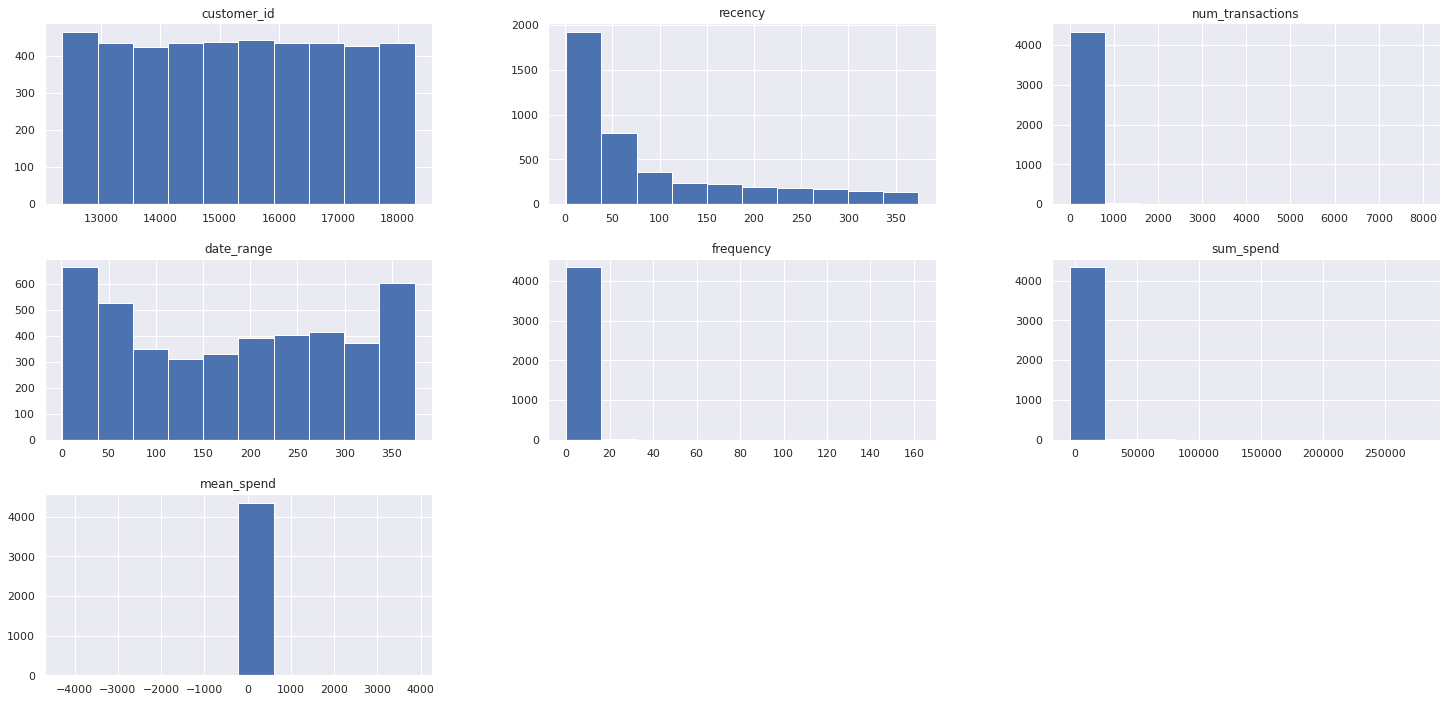

In [15]:
df3.hist();

In [79]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 

df3_t = df3.drop(columns = 'customer_id').copy()

# df3_t = df3_t.apply(lambda x: np.log1p(x[['recency', 'num_transactions', 'frequency', 'sum_spend', 'mean_spend']]), axis =1 )
# df3_t[['recency', 'num_transactions', 'frequency', 'sum_spend', 'mean_spend']] =df3_t[['recency', 'num_transactions', 'frequency', 'sum_spend', 'mean_spend']].apply(lambda x: np.log1p(x), axis =1 )
# df3_t.hist();
# ['recency', 'num_transactions', 'frequency', 'sum_spend', 'mean_spend']

log_cols = ['recency', 'num_transactions', 'frequency']
std_cols = ['sum_spend', 'mean_spend', 'date_range'] #+ log_cols
cat_cols = ['country']

log1p = FunctionTransformer(np.log1p)
ct_log = ColumnTransformer( transformers=[ ('log', log1p, log_cols),
('std', StandardScaler(), std_cols),
('cat', OrdinalEncoder(), cat_cols ) ] )
#pipe = make_pipeline( [ ct_log, MinMaxScaler() ], remainder = 'passthrough' )
pipe = make_pipeline( ct_log  )

res = pipe.fit_transform(df3_t, MinMaxScaler() )

# applying log and minmax scaler to log cols
log_pipe = Pipeline(steps = [ ('log', log1p), ('min_max', MinMaxScaler()) ] )
ct_log = ColumnTransformer( transformers = [ ('log', log_pipe, log_cols) ] ) 

# applying std scaler to std cols
std_pipe = make_pipeline( (StandardScaler() ) )

# Label Encoding and std_scaler to catgorical columns
label_pipe = make_pipeline( OrdinalEncoder(), StandardScaler() )

preprocessor = ColumnTransformer( 
    transformers=[ ('log', log_pipe, log_cols), 
    ('std', std_pipe, std_cols), 
    ('label', label_pipe, cat_cols) ])
res = preprocessor.fit_transform(df3_t)

res[1]


array([ 0.53562836,  0.55354923,  0.08846406,  0.14365808, -0.10312925,
        1.33606857,  0.29277964])

# 6.0 Feature Selection

## 6.1 Spliting Dataframe into Train Test 

## 6.2 Boruta Feature Selection

## 6.3 Results and Considerations

# 7.0 Model Testing

## Testing KMeans

In [88]:
from sklearn.cluster import KMeans
from sklearn import metrics as m

In [106]:
n_clusters = 10
silhouette = []

for n in range(2, n_clusters+1):
    # kmeans
    pipeline = make_pipeline( KMeans(n_clusters = n, random_state = 42) )
    labels = pipeline.fit_predict(res)

    #calculating silhouette score
    sil = m.silhouette_score(res, labels)
    silhouette.append(sil)

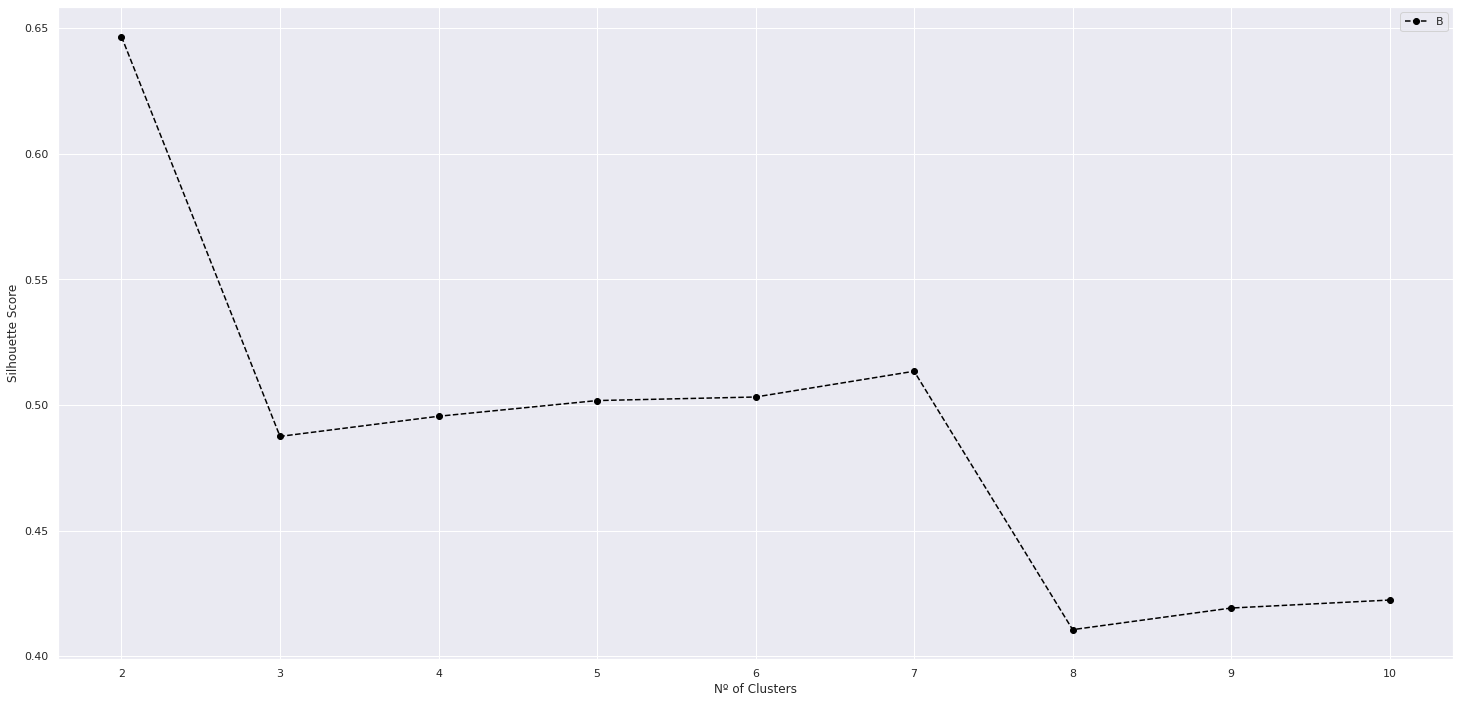

In [107]:
plt.plot(np.arange(2, n_clusters +1), silhouette, marker = 'o', linestyle = '--', color = 'black')
plt.legend('Baseline Silhouette Score for cycle 1 KMeans')
plt.xlabel('Nº of Clusters')
plt.ylabel('Silhouette Score');

## 7.2 Comparing Model's Performances

# 9.0 Error Interpretation

## 9.1 Total Performance - Business Perspective

## 9.2 Machine Learning Performance

# 10 Model Deployment